In [24]:
import pandas as pd
import numpy as np
df=pd.read_csv("BTC_1sec.csv")

In [26]:
df

,Unnamed: 0,system_time,midpoint,spread,buys,sells,bids_distance_0,bids_distance_1,bids_distance_2,bids_distance_3,...,asks_market_notional_5,asks_market_notional_6,asks_market_notional_7,asks_market_notional_8,asks_market_notional_9,asks_market_notional_10,asks_market_notional_11,asks_market_notional_12,asks_market_notional_13,asks_market_notional_14
0,0,2021-04-07 11:32:42.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2021-04-07 11:32:43.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2021-04-07 11:32:44.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,2021-04-07 11:32:45.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,2021-04-07 11:32:46.122161+00:00,56035.995,0.01,0.000000,0.000000,-8.922836e-08,-2.676851e-07,-0.000050,-0.000245,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1030723,1030723,2021-04-19 09:54:18.386544+00:00,56863.725,0.01,0.000000,0.000000,-8.792952e-08,-2.637886e-07,-0.000025,-0.000026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1030724,1030724,2021-04-19 09:54:19.386544+00:00,56863.725,0.01,0.000000,0.000000,-8.792952e-08,-2.637886e-07,-0.000026,-0.000031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1030725,1030725,2021-04-19 09:54:20.386544+00:00,56863.725,0.01,1506.866100,0.000000,-8.792952e-08,-2.637886e-07,-0.000026,-0.000034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1030726,1030726,2021-04-19 09:54:21.386544+00:00,56863.725,0.01,0.000000,0.000000,-8.792952e-08,-2.637886e-07,-0.000026,-0.000034,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
df['system_time']=pd.to_datetime(df['system_time'])

In [28]:
buys = df['buys'].values
sells = df['sells'].values


In [29]:
df['return']=np.log(df['midpoint']/df['midpoint'].shift(1))

In [30]:
df['net']=df['buys'] - df['sells']

In [31]:
df['ts'] = np.sign(df['net'])

In [32]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [33]:
def compute_autocorrelation(epsilon, max_lag=100):
    n = len(epsilon)
    acf_full = np.correlate(epsilon, epsilon, mode='full')
    mid = len(acf_full) // 2
    acf = acf_full[mid:mid + max_lag + 1]

    normalizer = np.array([n - lag for lag in range(0, max_lag + 1)])
    acf = acf / normalizer
    acf = acf / acf[0]
    return acf
epsilon = df['ts'].values

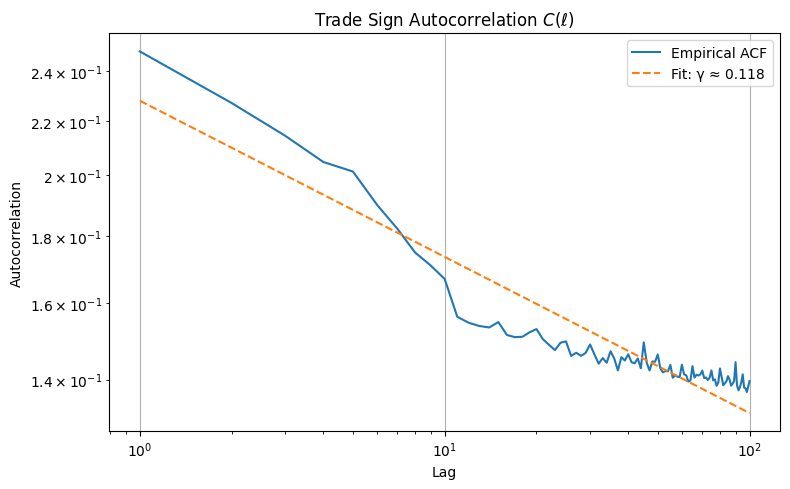

In [34]:
lags = np.arange(1, 101)
acf = compute_autocorrelation(epsilon, max_lag=100)[1:]


def power_law(x, gamma, a):
    return a * x ** (-gamma)

popt, _ = curve_fit(power_law, lags, acf, bounds=([0, 0], [2, 10]))
gamma_est, a_est = popt

# Plot it
plt.figure(figsize=(8, 5))
plt.loglog(lags, acf, label='Empirical ACF')
plt.loglog(lags, power_law(lags, *popt), '--', label=f'Fit: γ ≈ {gamma_est:.3f}')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Trade Sign Autocorrelation $C(\\ell)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:

L = 1000

gamma = gamma_est
beta_c = (1 - gamma) / 2

betas = [beta_c - 0.05, beta_c, beta_c + 0.05]

G_dict = {}
lags = np.arange(1, L+1)

for beta in betas:
    G_dict[beta] = lags ** (-beta)


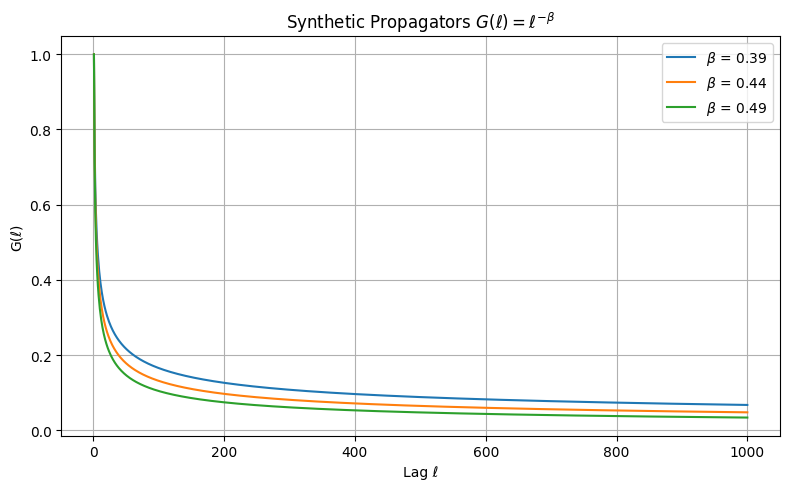

In [38]:
plt.figure(figsize=(8, 5))
for beta in G_dict:
    plt.plot(lags, G_dict[beta], label=f'$\\beta$ = {beta:.2f}')
plt.xlabel('Lag ℓ')
plt.ylabel('G(ℓ)')
plt.title('Synthetic Propagators $G(ℓ) = ℓ^{-\\beta}$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


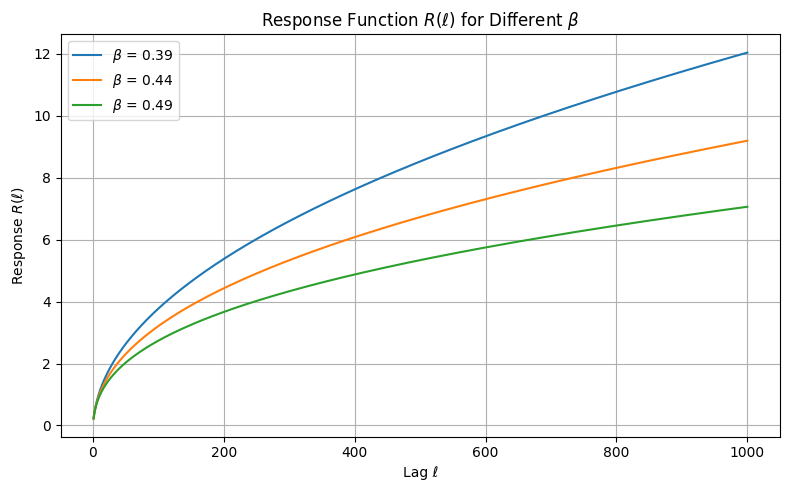

In [39]:

C = a_est * lags ** (-gamma_est)

R_dict = {}

for beta, G in G_dict.items():
    R = np.convolve(G, C, mode='full')[:L]  # Limit to first L lags
    R_dict[beta] = R

plt.figure(figsize=(8, 5))
for beta in sorted(R_dict):
    plt.plot(lags, R_dict[beta], label=f'$\\beta$ = {beta:.2f}')
plt.xlabel('Lag ℓ')
plt.ylabel('Response $R(ℓ)$')
plt.title('Response Function $R(ℓ)$ for Different $\\beta$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
from statsmodels.tsa.ar_model import AutoReg

p = 20
model = AutoReg(epsilon, lags=p, old_names=False).fit()
K = model.params[1:]

In [17]:
import numpy as np

epsilon_hat = np.convolve(epsilon, K[::-1], mode='valid')


In [45]:
surprise = epsilon[p:] - epsilon_hat[:-1]

In [47]:
from sklearn.linear_model import LinearRegression

returns = df['return'].values
model = LinearRegression().fit(surprise.reshape(-1, 1), returns[p:])
G1 = model.coef_[0]


In [48]:
G1

np.float64(2.426415323405014e-05)

In [49]:
returns_pred = G1 * surprise


In [ ]:
import numpy as np
from scipy.linalg import toeplitz, solve_toeplitz

def estimate_K_via_yule_walker(epsilon, p):

    n = len(epsilon)


    acf = np.correlate(epsilon, epsilon, mode='full')
    acf = acf[n-1:n+p] / n
    C = acf[:p]
    R = acf[1:p+1]
    K = solve_toeplitz((C, C), R)

    return K
p = 20
K_est = estimate_K_via_yule_walker(epsilon, p)


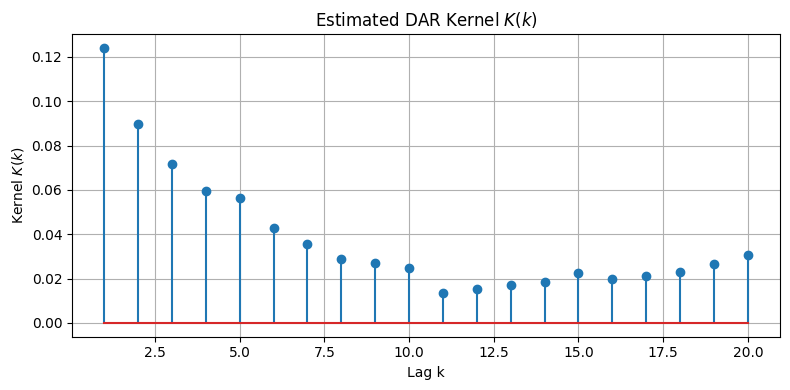

In [52]:

plt.figure(figsize=(8, 4))
plt.stem(np.arange(1, p+1), K_est)
plt.xlabel('Lag k')
plt.ylabel('Kernel $K(k)$')
plt.title('Estimated DAR Kernel $K(k)$')
plt.grid(True)
plt.tight_layout()
plt.show()


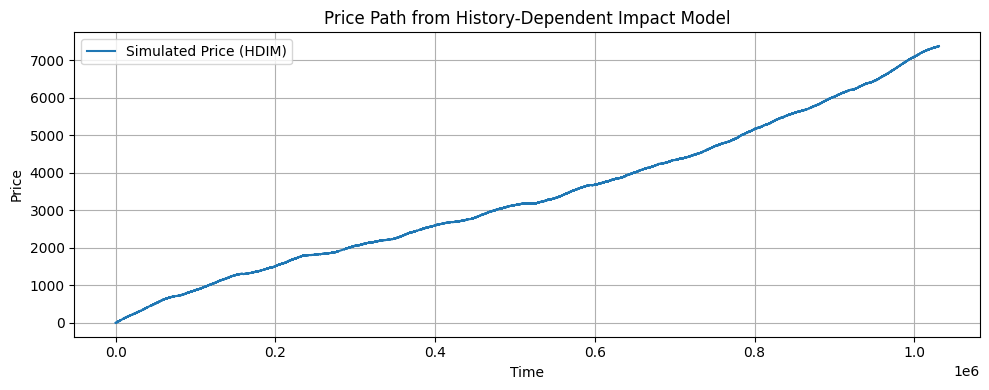

In [51]:

epsilon_hat = np.zeros_like(epsilon)
for t in range(p, len(epsilon)):
    epsilon_hat[t] = np.dot(K_est, epsilon[t-p:t][::-1])


surprise = epsilon - epsilon_hat


G1 = 0.1
noise = np.random.normal(loc=0, scale=0.01, size=len(epsilon))

returns = G1 * surprise + noise

price = np.cumsum(returns)

plt.figure(figsize=(10, 4))
plt.plot(price, label='Simulated Price (HDIM)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Price Path from History-Dependent Impact Model')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


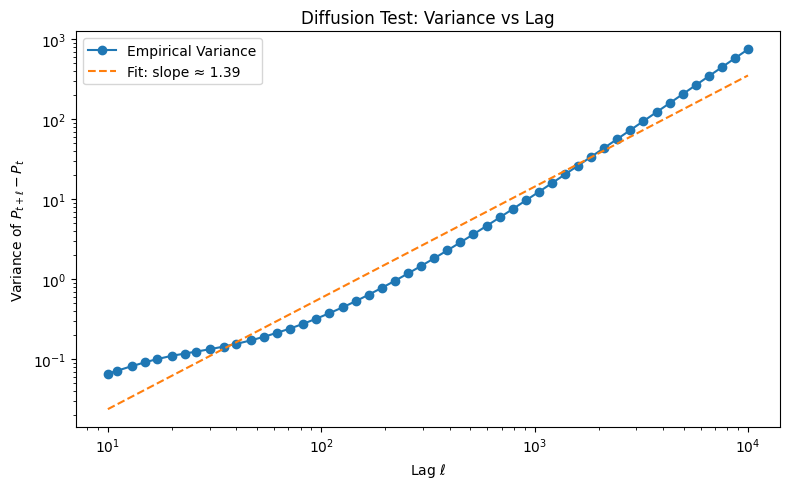

In [57]:

lags = np.logspace(1, 4, num=50, dtype=int)
variances = []

for lag in lags:
    diffs = price[lag:] - price[:-lag]
    var = np.var(diffs)
    variances.append(var)

plt.figure(figsize=(8, 5))
plt.loglog(lags, variances, marker='o', label='Empirical Variance')

slope, intercept = np.polyfit(np.log(lags), np.log(variances), 1)
plt.plot(lags, np.exp(intercept) * lags**slope, '--', label=f'Fit: slope ≈ {slope:.2f}')

plt.xlabel('Lag $\\ell$')
plt.ylabel('Variance of $P_{t+\\ell} - P_t$')
plt.title('Diffusion Test: Variance vs Lag')

plt.legend()
plt.tight_layout()
plt.show()
